In [1]:
import polars as pl

import numpy as np
import yaml
import gzip
import re
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from IPython.display import HTML 
#sckit learn

from sklearn.preprocessing  import StandardScaler, OneHotEncoder
from sklearn.manifold import MDS 
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from data_processor_polars import DataProcessor
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

### <span style="background-color: lightyellow;">Data retrieval task</span>
- Retrieve the data. (No cleaning needed yet)

In [2]:

def get_config(file_name):

    with open(file_name, 'r', encoding="UTF-8") as stream:
        config = yaml.safe_load(stream)
    return config


def parse_metadata(file_path):
    data = {}
    with gzip.open(file_path, 'rt') as f:
        lines = f.readlines()

    for line in lines:
        splited = line.split('\t', 1)
        if len(splited) >= 2:
            # Only include lines where the first part is '!Sample_title' or does not start with '!'
            if splited[0].strip() == '!Sample_title' or not splited[0].lstrip().startswith('!'):
                data[splited[0].strip()] = splited[1].strip().strip(
                    '"').split("\t")

    df = pl.LazyFrame(data)
    df = df.drop(['!Sample_title'])
    df = df.drop('"ID_REF"',)
    # df = df.apply(pl.to_numeric, errors='coerce')
    df = df.with_columns(
    pl.all().cast(pl.Float64, strict=False)  # Convert all **non-string** columns
)   
    return df.collect()


def retrieve_data():

    config = get_config('config.yaml')
    lung3 = config['lung3_csv']
    gene = config['gene']

    lung3_df = pl.read_csv(lung3)
    

    gene_expression_df = parse_metadata(gene)
    
    combined_df = gene_expression_df.with_columns([lung3_df[col] for col in lung3_df.columns])
    
    return combined_df


def sub_classification(histology):
    if "Carcinoma" in histology:
        return 'Carcinoma'
    elif "Adenocarcinoma" in histology:
        return 'Adenocarcinoma'
    else:
        return 'Others'

### <span style="background-color: lightyellow;">Feature engineering Task</span>

In [3]:
class FeatureProcessing(TransformerMixin, BaseEstimator): 
    def __init__(self, covariance_threshold=0, quantile_percentage=95, nan_threshold =35):
        self.covariance_threshold = covariance_threshold
        self.quantile_percentage = quantile_percentage
        self.nan_threshold= nan_threshold
        
    def fit(self, X, y=None):
        
        data_processor = DataProcessor(X)
        data_processor.remove_nonrelated_columns()
        data_processor.impute_notavailable_values('characteristics.tag.grade')
        data_processor.drop_nan_columns(self.nan_threshold)
        # data_processor.change_column_datatype()
        
        data_processor.cramerV(y, self.covariance_threshold)
        self.covarrianced_columns = data_processor.covarrianced_columns
        removed_catagorical_features = set(data_processor.find_cols_on_type(pl.String)) - set(self.covarrianced_columns)
        data_processor.drop_columns(column_list = list(removed_catagorical_features))
        data_processor.selecting_high_variance_gene_expression(self.quantile_percentage)
        self.features = data_processor.dataframe.columns
        
        self.scaler = StandardScaler()
        self.scaler.fit(data_processor.dataframe[data_processor.find_cols_on_type(pl.Float64)])
        
        self.one_hot_encoder= OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.one_hot_encoder.fit(data_processor.dataframe[data_processor.covarrianced_columns])
        self.processed_df = data_processor.dataframe
        return self
    
    def transform(self, X):
    
       data_processor = DataProcessor(X)
       data_processor.dataframe = data_processor.dataframe[self.features]
       data_processor.fit_standard_scaling(self.scaler)
       data_processor.encoding_catagorical_features(self.one_hot_encoder, self.covarrianced_columns)
       data_processor.dataframe = data_processor.dataframe.fill_null(value=0)
       
       X = data_processor.dataframe

       return X

### <span style="background-color: lightyellow;">Evaluation Task</span>

In [4]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

class Evaluator:
    def __init__(self, model,):
        pass
        
    @staticmethod
    def eval(y_pred, test_y, print_result = False):
        
        accuracy = accuracy_score(test_y, y_pred)

        if print_result:
            report = classification_report(test_y, y_pred, zero_division=0)
            matrix = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pred, test_y))
            print("Model testing complete.")
            print(f"Accuracy: {accuracy}")
            print("\nClassification Report:\n", report)
            print("\nMatrix:\n")
            matrix.plot()

        return accuracy



### <span style="background-color: lightyellow;">Pipeline Task</span>


In [5]:
from sklearn.preprocessing import LabelEncoder
from codecarbon import track_emissions
def return_train_test_split():
    encoder = LabelEncoder()
    dataset = retrieve_data()
    y = dataset["characteristics.tag.histology"].map_elements(lambda x: sub_classification(x), return_dtype=pl.String)
    y_encoded = pl.DataFrame(encoder.fit_transform(y)).to_series()
    X = dataset.drop('characteristics.tag.histology')
    # Before doing any preprocessing steps we will split the data into train and test inorder to prevent data leakage
    train_X, test_X, train_y, test_y = train_test_split(X, y_encoded, random_state=42)
    return train_X, test_X, train_y, test_y 


In [6]:
@track_emissions
def run_feature_processing():
    train_X, test_X, train_y, test_y = return_train_test_split()
    print("###### Feature processing ######")
    fp = FeatureProcessing()
    fp.fit(train_X,train_y)
    x = fp.transform(train_X)
    
run_feature_processing()

[codecarbon INFO @ 00:09:59] [setup] RAM Tracking...
[codecarbon INFO @ 00:09:59] [setup] GPU Tracking...
[codecarbon INFO @ 00:09:59] No GPU found.
[codecarbon INFO @ 00:09:59] [setup] CPU Tracking...
[codecarbon WARNING @ 00:09:59] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 00:10:00] We saw that you have a Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz but we don't know it. Please contact us.
[codecarbon INFO @ 00:10:00] CPU Model on constant consumption mode: Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz
[codecarbon INFO @ 00:10:00] >>> Tracker's metadata:
[codecarbon INFO @ 00:10:00]   Platform system: Linux-6.1.0-31-amd64-x86_64-with-glibc2.36
[codecarbon INFO @ 00:10:00]   Python version: 3.12.3
[codecarbon INFO @ 00:10:00]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 00:10:00]   Available RAM : 880.353 GB
[codecarbon INFO @ 00:10:00]   CPU count: 80
[codecarbon INFO @ 00:10:00]   CPU model: Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz
[codecarbon INF

###### Feature processing ######


/homes/rmeshita/Documents/Programming_6/Green_ML/data_processor_polars.py:170: RuntimeWarning: Unable to calculate Cramer's V using bias correction. Consider not using bias correction
  warnings.warn(
/homes/rmeshita/Documents/Programming_6/Green_ML/data_processor_polars.py:170: RuntimeWarning: Unable to calculate Cramer's V using bias correction. Consider not using bias correction
  warnings.warn(
/homes/rmeshita/Documents/Programming_6/Green_ML/data_processor_polars.py:170: RuntimeWarning: Unable to calculate Cramer's V using bias correction. Consider not using bias correction
  warnings.warn(
/homes/rmeshita/Documents/Programming_6/Green_ML/data_processor_polars.py:170: RuntimeWarning: Unable to calculate Cramer's V using bias correction. Consider not using bias correction
  warnings.warn(
/homes/rmeshita/Documents/Programming_6/Green_ML/data_processor_polars.py:170: RuntimeWarning: Unable to calculate Cramer's V using bias correction. Consider not using bias correction
  warnings.w

[codecarbon INFO @ 12:36:46] [setup] RAM Tracking...
[codecarbon INFO @ 12:36:46] [setup] GPU Tracking...
[codecarbon INFO @ 12:36:46] No GPU found.
[codecarbon INFO @ 12:36:46] [setup] CPU Tracking...
[codecarbon WARNING @ 12:36:46] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 12:36:48] We saw that you have a Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz but we don't know it. Please contact us.
[codecarbon INFO @ 12:36:48] CPU Model on constant consumption mode: Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz
[codecarbon INFO @ 12:36:48] >>> Tracker's metadata:
[codecarbon INFO @ 12:36:48]   Platform system: Linux-6.1.0-31-amd64-x86_64-with-glibc2.36
[codecarbon INFO @ 12:36:48]   Python version: 3.12.3
[codecarbon INFO @ 12:36:48]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 12:36:48]   Available RAM : 880.353 GB
[codecarbon INFO @ 12:36:48]   CPU count: 80
[codecarbon INFO @ 12:36:48]   CPU model: Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz
[codecarbon INF

###### Model: XGboost ######


/homes/rmeshita/Documents/Programming_6/Green_ML/data_processor_polars.py:170: RuntimeWarning: Unable to calculate Cramer's V using bias correction. Consider not using bias correction
  warnings.warn(
/homes/rmeshita/Documents/Programming_6/Green_ML/data_processor_polars.py:170: RuntimeWarning: Unable to calculate Cramer's V using bias correction. Consider not using bias correction
  warnings.warn(
/homes/rmeshita/Documents/Programming_6/Green_ML/data_processor_polars.py:170: RuntimeWarning: Unable to calculate Cramer's V using bias correction. Consider not using bias correction
  warnings.warn(
/homes/rmeshita/Documents/Programming_6/Green_ML/data_processor_polars.py:170: RuntimeWarning: Unable to calculate Cramer's V using bias correction. Consider not using bias correction
  warnings.warn(
/homes/rmeshita/Documents/Programming_6/Green_ML/data_processor_polars.py:170: RuntimeWarning: Unable to calculate Cramer's V using bias correction. Consider not using bias correction
  warnings.w

Model testing complete.
Accuracy: 0.8260869565217391

Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       0.83      0.91      0.87        11
           2       0.00      0.00      0.00         3

    accuracy                           0.83        23
   macro avg       0.55      0.64      0.59        23
weighted avg       0.72      0.83      0.77        23


Matrix:



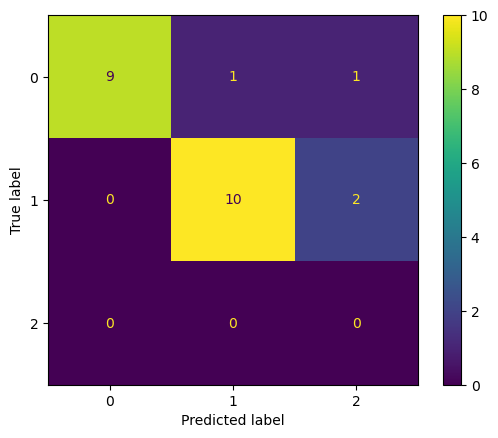

In [13]:

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import xgboost as xgb

@track_emissions
def run_xgbbost_pipeline():
    train_X, test_X, train_y, test_y = return_train_test_split()
    print("###### Model: XGboost ######")
    pipeline = Pipeline([('feature-processing', FeatureProcessing()), ('model', xgb.XGBClassifier(tree_method="hist"))])
    pipeline.fit(train_X, train_y)
    preds = pipeline.predict(test_X)
    Evaluator.eval(preds,test_y, print_result=True)

run_xgbbost_pipeline()


[codecarbon INFO @ 12:37:29] [setup] RAM Tracking...
[codecarbon INFO @ 12:37:29] [setup] GPU Tracking...
[codecarbon INFO @ 12:37:29] No GPU found.
[codecarbon INFO @ 12:37:29] [setup] CPU Tracking...
[codecarbon WARNING @ 12:37:29] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 12:37:31] We saw that you have a Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz but we don't know it. Please contact us.
[codecarbon INFO @ 12:37:31] CPU Model on constant consumption mode: Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz
[codecarbon INFO @ 12:37:31] >>> Tracker's metadata:
[codecarbon INFO @ 12:37:31]   Platform system: Linux-6.1.0-31-amd64-x86_64-with-glibc2.36
[codecarbon INFO @ 12:37:31]   Python version: 3.12.3
[codecarbon INFO @ 12:37:31]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 12:37:31]   Available RAM : 880.353 GB
[codecarbon INFO @ 12:37:31]   CPU count: 80
[codecarbon INFO @ 12:37:31]   CPU model: Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz
[codecarbon INF

###### Model: Gaussian NB ######


/homes/rmeshita/Documents/Programming_6/Green_ML/data_processor_polars.py:170: RuntimeWarning: Unable to calculate Cramer's V using bias correction. Consider not using bias correction
  warnings.warn(
/homes/rmeshita/Documents/Programming_6/Green_ML/data_processor_polars.py:170: RuntimeWarning: Unable to calculate Cramer's V using bias correction. Consider not using bias correction
  warnings.warn(
/homes/rmeshita/Documents/Programming_6/Green_ML/data_processor_polars.py:170: RuntimeWarning: Unable to calculate Cramer's V using bias correction. Consider not using bias correction
  warnings.warn(
/homes/rmeshita/Documents/Programming_6/Green_ML/data_processor_polars.py:170: RuntimeWarning: Unable to calculate Cramer's V using bias correction. Consider not using bias correction
  warnings.warn(
/homes/rmeshita/Documents/Programming_6/Green_ML/data_processor_polars.py:170: RuntimeWarning: Unable to calculate Cramer's V using bias correction. Consider not using bias correction
  warnings.w

Model testing complete.
Accuracy: 0.8260869565217391

Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       0.83      0.91      0.87        11
           2       0.00      0.00      0.00         3

    accuracy                           0.83        23
   macro avg       0.55      0.64      0.59        23
weighted avg       0.72      0.83      0.77        23


Matrix:



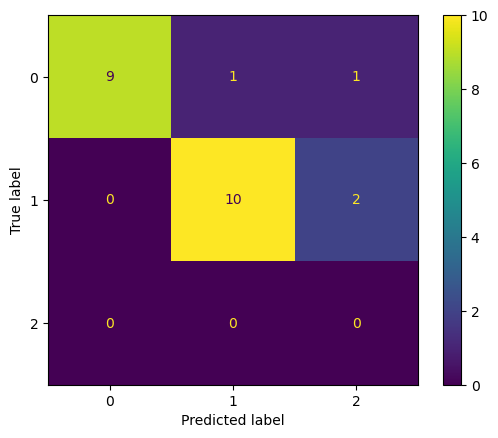

In [14]:
@track_emissions
def run_naive_bayes_pipeline():
    train_X, test_X, train_y, test_y = return_train_test_split()
    print("###### Model: Gaussian NB ######")
    pipeline1 = Pipeline([('feature-processing', FeatureProcessing()), ('model', GaussianNB())])
    pipeline1.fit(train_X, train_y)
    preds = pipeline1.predict(test_X)
    Evaluator.eval(preds,test_y, print_result=True)
run_naive_bayes_pipeline()